**Name: Chandan Suri, CS4090**

In collaboration with Gursifath Bhasin, GB2760

## GANs : Generative Adversarial Networks 


Image from [here]()
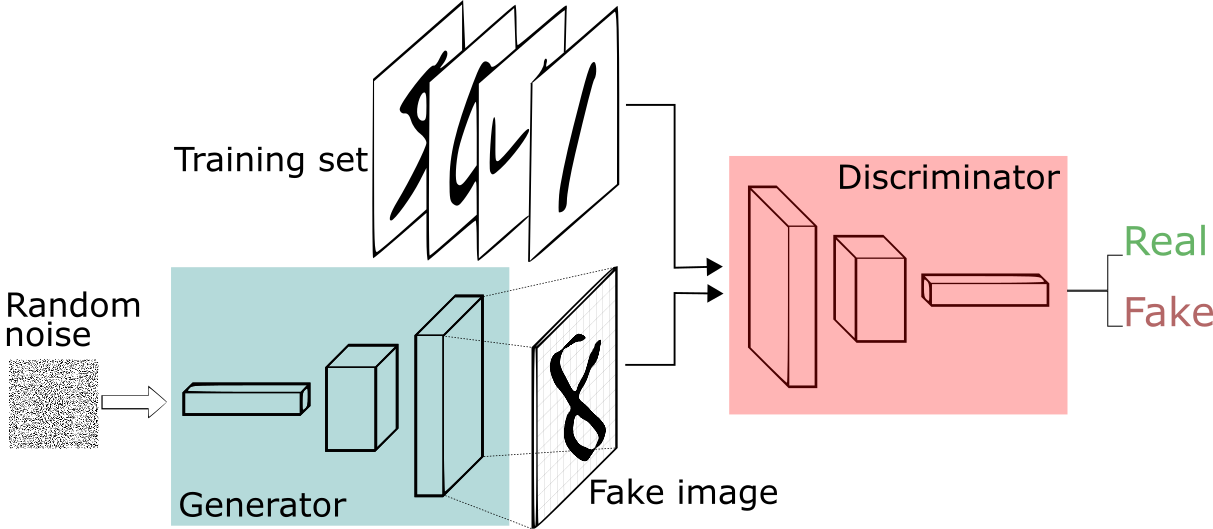

A generative adversarial network (GAN) is a generative model composed of two neural networks: a generator and a discriminator. These two networks are trained in unsupervised way via competition. The generator creates ”realistic” fake images from random noise to fool the discriminator, while the discriminator evaluates the given image for authenticity. 
The loss function that the generator wants to minimize and the discriminator to maximize is as follows: 

min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))] 

Here, G and D are the generator and the discriminator. The first and second term of the loss represent the correct prediction of the discriminator on the real images and on the fake images respectively. 




## DCGAN

• You will implement deep convolutional GAN model on the MNIST dataset with Pytorch. The input image size is 28 x 28. 

• The details of the generator of DCGAN is described below. 

• You will start with batch size of 128, input noise of 100 dimension and Adam optimizer with learning rate of 2e-4. You may vary these hyperparameters for better performance. 

## Architectures


Generator: 

The goal for the generator is to use layers such as convolution, maybe also upsampling layer/transposedConvolution to produce image from the given input noise vector. As this is DCGAN (deep convolutional GAN), we expect you to use convolution in the generator. You will get full credit if you can produce `[batchsize, 1, 28, 28]` vector (image) from the given `[batchsize, 100, 1, 1]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.UpsamplingBilinear2d

• torch.nn.ConvTranspose2d

Non-linear layer: 
 
• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Tanh for the last layer's activation. Can you explain why do we need this in the code comment?


You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

We recommend to use 2 Conv/TransposedConv layers. When you are increasing the feature map size, considering upsample the feature by a factor of 2 each time. If you have width of 7 in one of your feature map, to get output with width of 28, you can do upsampling with factor of 2 and upsampling 2 times. 

Discriminator:

You will get full credit if you can produce an output of `[batchsize, 1]` vector (image) from the given input `[batchsize, 1, 28, 28]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.Linear

Non-linear Layers: 

• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Sigmoid for the last layer's activation. Can you explain why do we need this in the code comment?

Use Leaky ReLu as the activation function between all layers, except after the last layer use Sigmoid.

You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

As an example, you may use 2 convolution layer and one linear layer in the discriminator, you can also use other setup. Note that instead of using pooling to downsampling, you may also use stride=2 in convolution to downsample the feature.

In [1]:
# NOTE: Referenced From: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

from torchvision.transforms.transforms import Normalize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5), (0.5))])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw




## Model Definition (TODO)

In [2]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        
        self.gen_net = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 7, 1, 0, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias = False),
            nn.Tanh()
        )
        

    def forward(self, input):

        out = self.gen_net(input)
        # Explain why Tanh is needed for the last layer
        '''
        Answer: As we need to propagate more losses when the pixel changes are 
        there in the lower range rather than in the higher brightness range, we
        want to use a similar activation for our last layer such that the 
        generator generates data accordingly and in accordance with how our eyes
        perceive the image data. To model a similar behaviour as we are randomly
        generating the data here, we need an activation that models the same for
        us.
        '''

        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()

        self.disc_net = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),

            nn.Flatten(),

            # This is added to create a single output 
            # and the number is actually the number of nodes coming out of 
            # the previous layer
            nn.Linear(64*7*7, 1),
            nn.Sigmoid()
        )
        
    
    def forward(self, input):

        out = self.disc_net(input)

        # Explain why Sigmoid is needed for the last layer
        '''
        Answer: As we are doing Binary Classification here from the discriminator,
        Real or Fake, for which we would need to calculate the losses using the
        logits/probabilities for the classes predicted and the target variable,
        we need to use Sigmoid function which gives us the inputs as needed for
        our problem statement and use case at hand.
        '''
        
        return out


# Code that check size
g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]

d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


GAN loss (TODO)

In [3]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images (and remember to detach the gradient from the fake images using detach()!)
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    # Step-1
    output = D(real).view(-1)
    # Step-2
    loss_D_real = criterion(output, Valid_label)
    
    # Step-3
    fake_imgs = G(noise)
    # Step-4
    output = D(fake_imgs.detach()).view(-1)
    # Step-5
    loss_D_fake = criterion(output, Fake_label)

    # Step-6
    loss_D = loss_D_real + loss_D_fake

    # Step-7
    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    # Step-1
    output = netD(fake).view(-1)
    # Step-2
    loss_G = criterion(output, Valid_label)
    
    return loss_G

In [4]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 7, 7]       1,254,400
       BatchNorm2d-2            [-1, 256, 7, 7]             512
         LeakyReLU-3            [-1, 256, 7, 7]               0
   ConvTranspose2d-4          [-1, 128, 14, 14]         524,288
       BatchNorm2d-5          [-1, 128, 14, 14]             256
         LeakyReLU-6          [-1, 128, 14, 14]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]           2,048
              Tanh-8            [-1, 1, 28, 28]               0
Total params: 1,781,504
Trainable params: 1,781,504
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.87
Params size (MB): 6.80
Estimated Total Size (MB): 7.67
----------------------------------------------------------------
None
---------------------------------

TRAINING

[0/50][0/600]	Loss_D: 1.4879	Loss_G: 0.7396	
[0/50][50/600]	Loss_D: 0.9982	Loss_G: 1.2716	
[0/50][100/600]	Loss_D: 1.0149	Loss_G: 0.9976	
[0/50][150/600]	Loss_D: 0.8708	Loss_G: 1.6635	
[0/50][200/600]	Loss_D: 0.9862	Loss_G: 0.5605	
[0/50][250/600]	Loss_D: 0.6969	Loss_G: 1.4499	
[0/50][300/600]	Loss_D: 0.6374	Loss_G: 1.5965	
[0/50][350/600]	Loss_D: 0.7565	Loss_G: 1.3539	
[0/50][400/600]	Loss_D: 0.5479	Loss_G: 1.4173	
[0/50][450/600]	Loss_D: 0.6118	Loss_G: 1.6015	
[0/50][500/600]	Loss_D: 0.7931	Loss_G: 2.2450	
[0/50][550/600]	Loss_D: 0.5484	Loss_G: 1.3746	
[1/50][0/600]	Loss_D: 0.6386	Loss_G: 1.5929	
[1/50][50/600]	Loss_D: 0.9290	Loss_G: 2.1992	
[1/50][100/600]	Loss_D: 0.5651	Loss_G: 2.1194	
[1/50][150/600]	Loss_D: 0.6655	Loss_G: 1.3556	
[1/50][200/600]	Loss_D: 0.7413	Loss_G: 0.8428	
[1/50][250/600]	Loss_D: 0.6750	Loss_G: 1.3255	
[1/50][300/600]	Loss_D: 0.5497	Loss_G: 1.5126	
[1/50][350/600]	Loss_D: 0.6765	Loss_G: 2.6269	
[1/50][400/600]	Loss_D: 0.5722	Loss_G: 2.0290	
[1/50][450/600]	Los

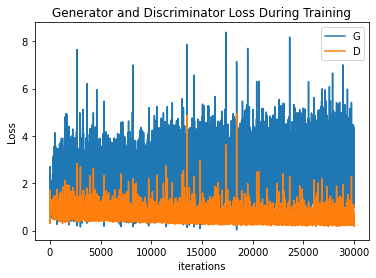

In [5]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D

################################
# Please fill in your code here:

optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

################################



img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 50 # Changed this to get better results

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        loss_D, fake_imgs = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion, optimizerD)

        loss_D.backward()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()

        loss_G = loss_generator(netD, netG, fake_imgs, Valid_label, criterion, optimizerG)

        loss_G.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))




## Qualitative Visualisations

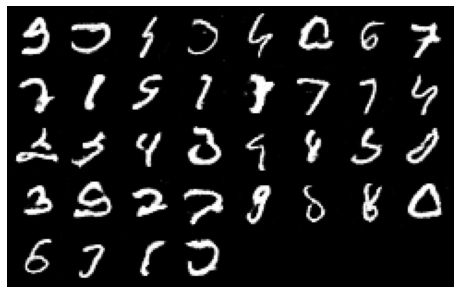

In [6]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())